# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

**Valentina Krabbe - 45207992**

## Instalar librerias

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [2]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [4]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [5]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [6]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [7]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [8]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.000
Episodio 400: Tasa de éxito = 0.005
Episodio 600: Tasa de éxito = 0.012
Episodio 800: Tasa de éxito = 0.014
Episodio 1000: Tasa de éxito = 0.012

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.012
Recompensa promedio: 0.012


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [9]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [10]:
politica_aleatoria

array([3, 0, 1, 0, 1, 0, 2, 3, 3, 2, 2, 3, 2, 1, 0, 3])

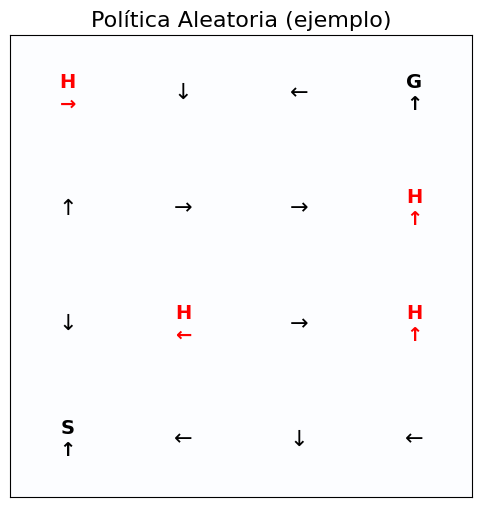

In [11]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [12]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [13]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.620, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [14]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.589
Pasos promedio: 37.2


## Visualizar política aprendida

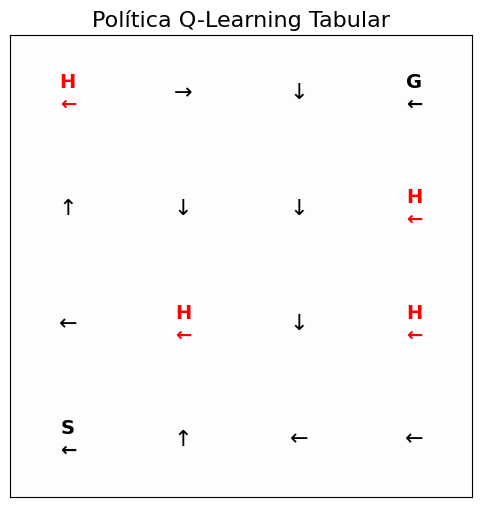

In [15]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

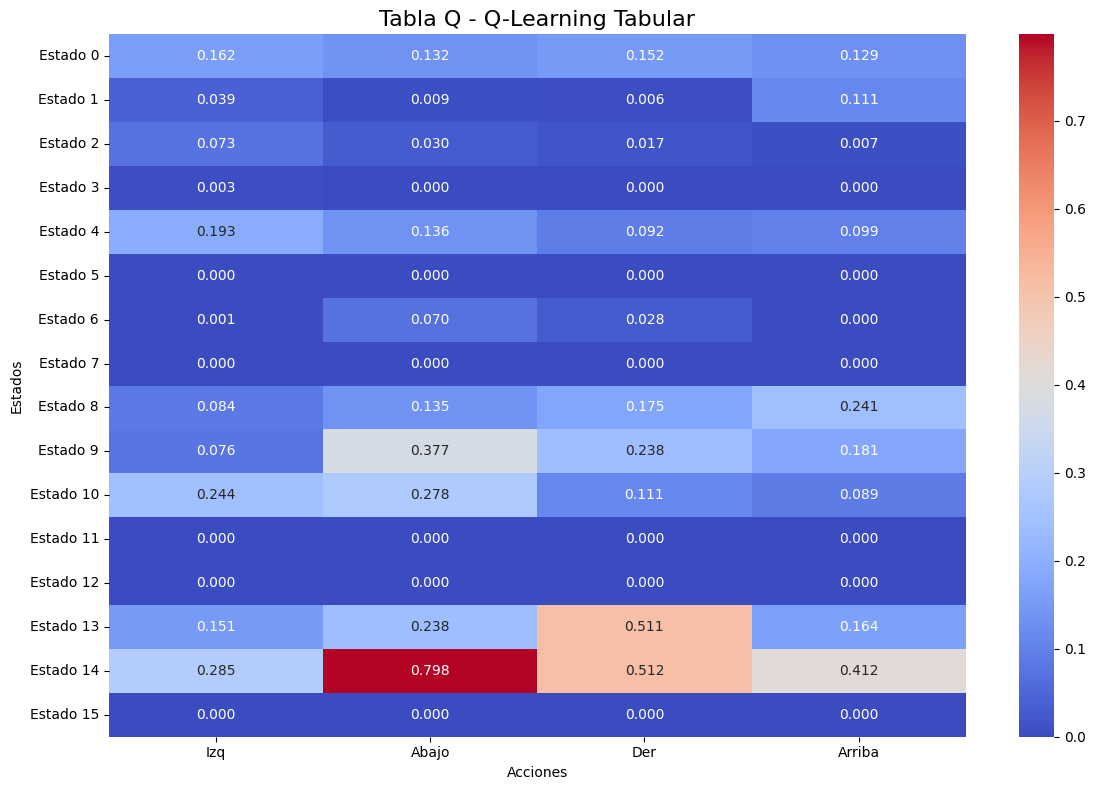

In [16]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [17]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [18]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [61]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [62]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.050, Epsilon = 0.367, Loss = 0.0022
Episodio 400: Tasa éxito = 0.240, Epsilon = 0.135, Loss = 0.0071
Episodio 600: Tasa éxito = 0.440, Epsilon = 0.049, Loss = 0.0073
Episodio 800: Tasa éxito = 0.520, Epsilon = 0.018, Loss = 0.0084
Episodio 1000: Tasa éxito = 0.500, Epsilon = 0.010, Loss = 0.0084

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [63]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.289
Pasos promedio: 27.5


## Visualizar política aprendida

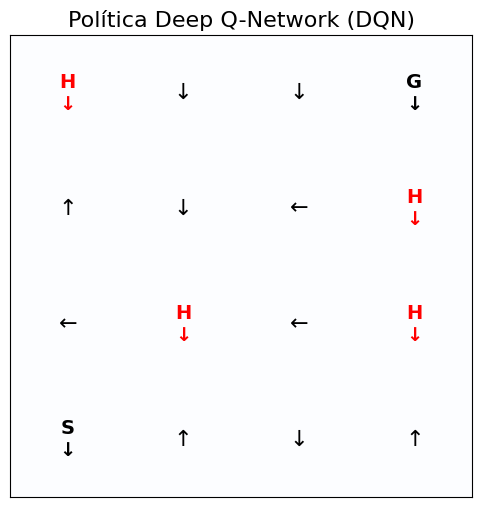

In [64]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [65]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.012
Q-Learning Tabular:    Tasa de éxito = 0.589
Deep Q-Network (DQN):  Tasa de éxito = 0.289


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [66]:
len(recompensas_aleatorio)

1000

In [67]:
len(recompensas_qlearning)

1000

In [68]:
len(recompensas_dqn)

1000

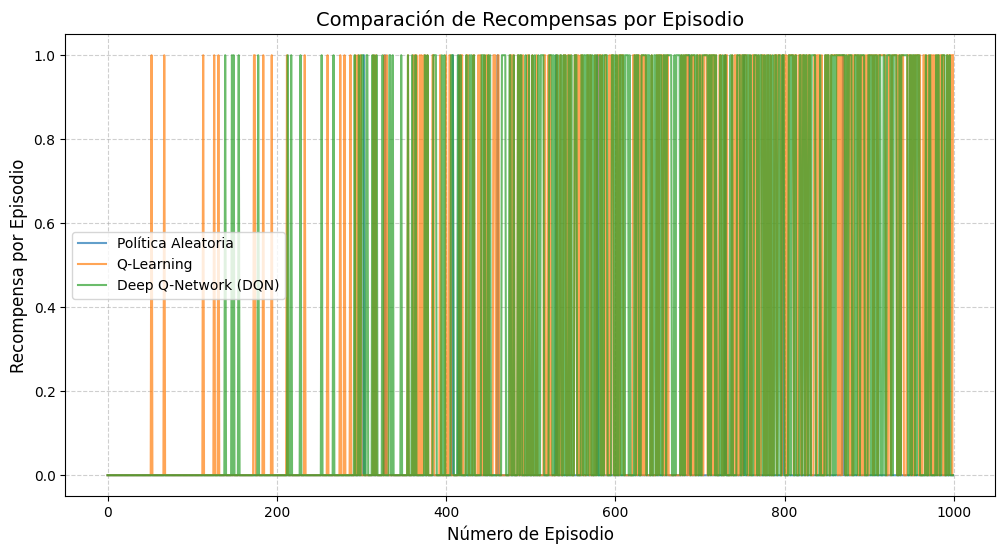

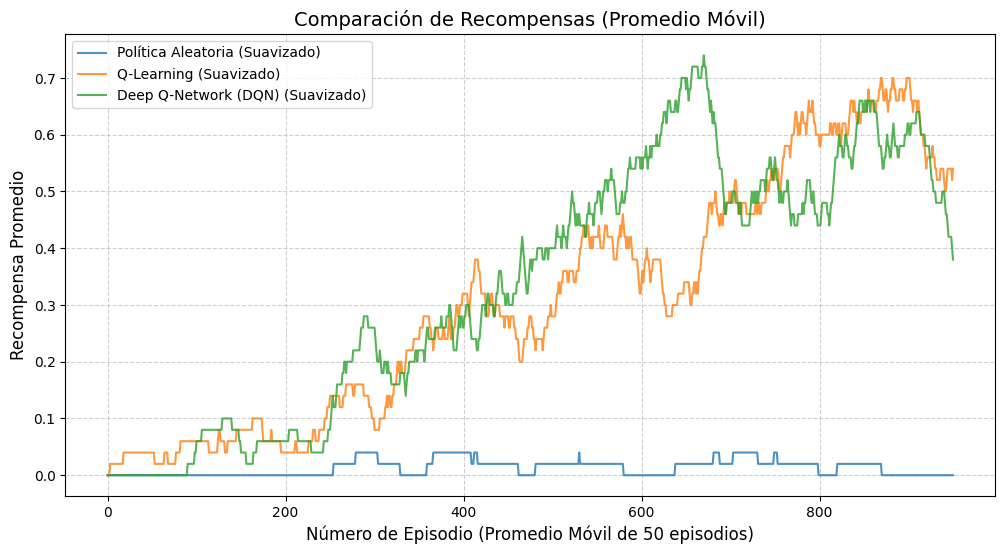

In [69]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

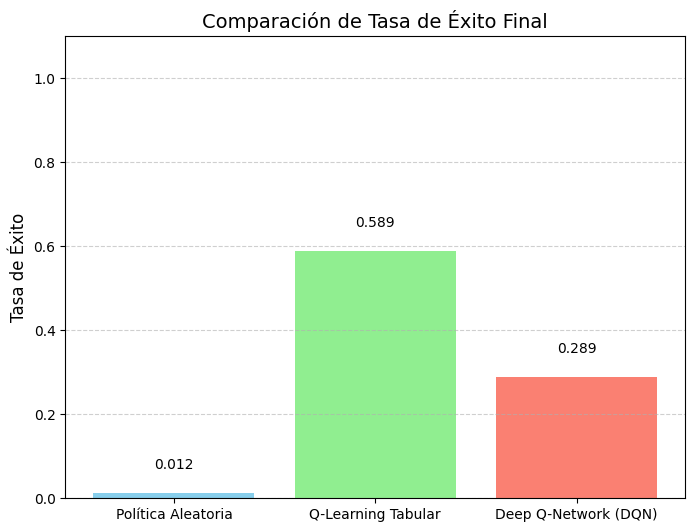

In [70]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### DQN pérdida

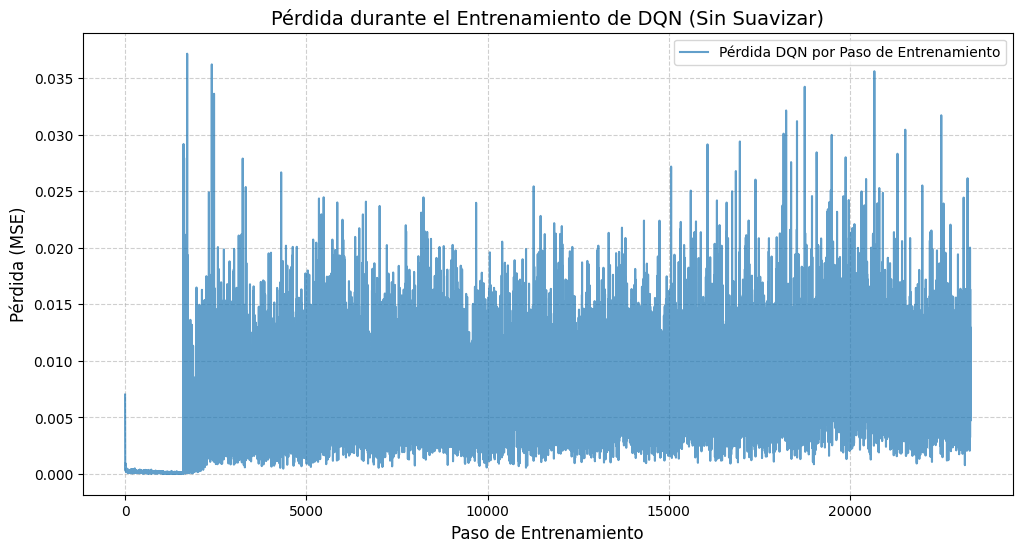

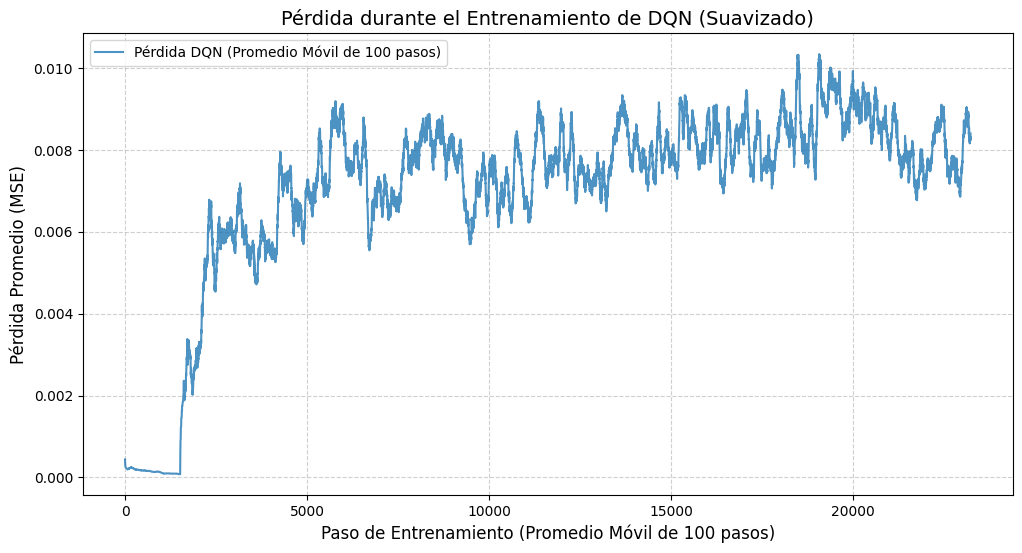

In [71]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






##**Con agente aleatorio**
En el caso de este agente, no sirve de nada entrenarlo mas episodios porque trabaja de forma aleatria, no tiene memoria ni valores Q.

In [30]:
#Creamos un nuevo agente
agente_aleat_mas_epi=PoliticaAleatoria(env.action_space.n)

# La política aleatoria no necesita ser entrenada, solo evaluada
recompensas_aleatorio_mas_epi, tasa_exito_aleatorio_mas_epi = agente_aleat_mas_epi.entrenar(env, episodios=5000)


🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.020
Episodio 400: Tasa de éxito = 0.020
Episodio 600: Tasa de éxito = 0.020
Episodio 800: Tasa de éxito = 0.019
Episodio 1000: Tasa de éxito = 0.019
Episodio 1200: Tasa de éxito = 0.018
Episodio 1400: Tasa de éxito = 0.017
Episodio 1600: Tasa de éxito = 0.016
Episodio 1800: Tasa de éxito = 0.016
Episodio 2000: Tasa de éxito = 0.015
Episodio 2200: Tasa de éxito = 0.016
Episodio 2400: Tasa de éxito = 0.015
Episodio 2600: Tasa de éxito = 0.016
Episodio 2800: Tasa de éxito = 0.015
Episodio 3000: Tasa de éxito = 0.016
Episodio 3200: Tasa de éxito = 0.016
Episodio 3400: Tasa de éxito = 0.016
Episodio 3600: Tasa de éxito = 0.016
Episodio 3800: Tasa de éxito = 0.016
Episodio 4000: Tasa de éxito = 0.016
Episodio 4200: Tasa de éxito = 0.016
Episodio 4400: Tasa de éxito = 0.016
Episodio 4600: Tasa de éxito = 0.015
Episodio 4800: Tasa de éxito = 0.015
Episodio 5000: Tasa de éxito = 0.016

📊 Resultados Política Aleatoria:
Tasa de éxi

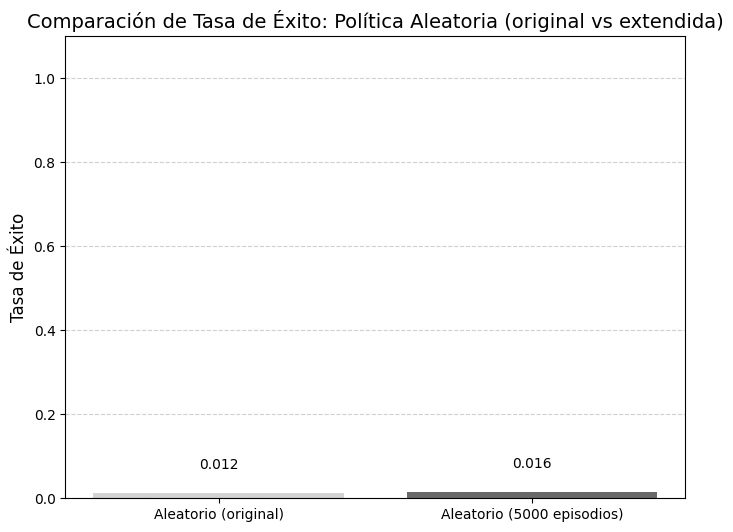

In [31]:
metricas = ['Aleatorio (original)', 'Aleatorio (5000 episodios)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_aleatorio_mas_epi]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['lightgray', 'dimgray'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito: Política Aleatoria (original vs extendida)', fontsize=14)
plt.ylim(0, 1.1)

for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Bueno podemos ver en el grafico que al aumentar los episodios la politica aleatoria no aplica un mejor rendimiento ya que este agente no tiene memoria ni actualización de politica, solo explora acciones sin aprender.

##**Con Q-Learning**

In [32]:
#Creamos un nuevo agente
agente_ql_mas_epi= QLearningTabular(
    n_estados=env.observation_space.n,
    n_acciones=env.action_space.n,
    lr=0.1,
    gamma=0.95,
    epsilon=1.0
)

In [33]:
#Lo entrenamos con mas episodios que antes (5000)
recompensas_mas_epi= agente_ql_mas_epi.entrenar(env, episodios=5000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.590, Epsilon = 0.010
Episodio 2000: Tasa éxito (últimos 100) = 0.590, Epsilon = 0.010
Episodio 3000: Tasa éxito (últimos 100) = 0.540, Epsilon = 0.010
Episodio 4000: Tasa éxito (últimos 100) = 0.590, Epsilon = 0.010
Episodio 5000: Tasa éxito (últimos 100) = 0.680, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


In [34]:
#Evaluamos el agente extendido
tasa_exito_mas_epi, recompensas_eval_as_epi= agente_ql_mas_epi.evaluar(env, episodios=1000)



📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.637
Pasos promedio: 38.8


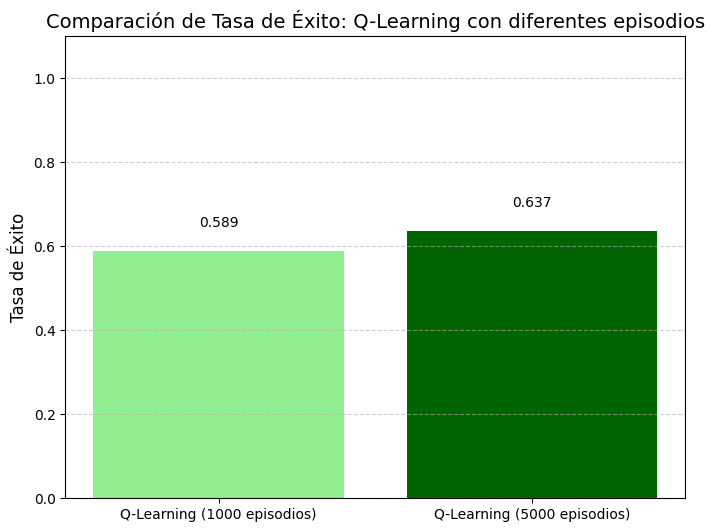

In [49]:
import matplotlib.pyplot as plt

metricas = ['Q-Learning (1000 episodios)', 'Q-Learning (5000 episodios)']
tasas_exito = [tasa_exito_qlearning, tasa_exito_mas_epi]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['lightgreen', 'darkgreen'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito: Q-Learning con diferentes episodios', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

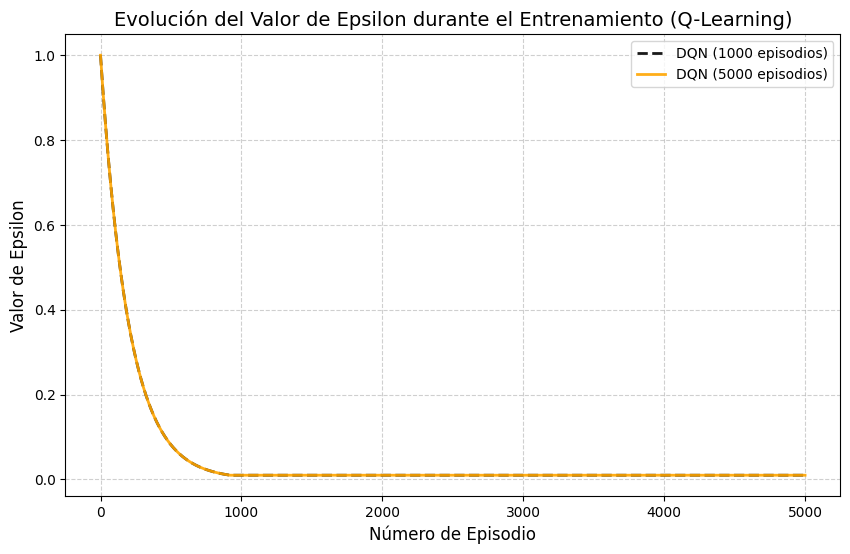

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(agente_ql_mas_epi.epsilons, label='DQN (1000 episodios)',  color='black', linestyle='--', linewidth=2, alpha=0.9)
plt.plot(agente_ql_mas_epi.epsilons, label='DQN (5000 episodios)', color='orange',linewidth=2, alpha=0.9)


plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento (Q-Learning)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### **GRAFICO TASA DE EXITO Q-LEARNING**
Entrenamos a dos agentes identicos, uno con 1000 episodios y otro con 5000.
Para la gran diferencia de episodios, no se justifica el incremento de la tasa de exito, ya que varia muy poco y es mucho mayor el tiempo de entrenamiento.


### **GRAFICO: Evolución del Valor de Epsilon durante el Entrenamiento (Q-Learning)**

Este grafico se centra en como varia **epsilon** en los dos agentes y sus episodios.

**Epsilon (ε)** es uno de los parametros mas importantes en Q-Learning y DQN. Este controla el equilibrio  entre _**EXPLORAR Y EXPLOTAR**_. Representa la probabilidad de explorar en lugar de explotar, es un numero entre 0 y 1.

Este parametro comienza en un valor alto (ej 1.0) porque necesita explorar el entorno, y a medida que explora y aprende, este va disminuyendo. Hay funciones que definen el comportamiento de este, como **def decay_epsilon()** que controla cómo baja epsilon con el tiempo para explotar mas que explorar.

Entonces podemos decir que este grafico muestra la transicion entre explorar y explotar. En este caso podemos ver como despues de los 1000 episodios los agentes se mantienen en una linea, lo que indica que coienzan a explotar 100%.

##**Agente DQN**

In [72]:
agente_dqn_mas_epi = DQNAgent(
    state_size=env.observation_space.n,
    action_size=env.action_space.n,
    lr=0.001,
    gamma=0.95,
    epsilon=1.0)

🖥️ Usando dispositivo: cpu


In [73]:
#Lo entrenamos con mas episodios que antes
recompensas_mas_epi= agente_dqn_mas_epi.entrenar(env, episodios=5000)

🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.070, Epsilon = 0.367, Loss = 0.0097
Episodio 400: Tasa éxito = 0.180, Epsilon = 0.135, Loss = 0.0078
Episodio 600: Tasa éxito = 0.310, Epsilon = 0.049, Loss = 0.0056
Episodio 800: Tasa éxito = 0.370, Epsilon = 0.018, Loss = 0.0076
Episodio 1000: Tasa éxito = 0.470, Epsilon = 0.010, Loss = 0.0070
Episodio 1200: Tasa éxito = 0.470, Epsilon = 0.010, Loss = 0.0086
Episodio 1400: Tasa éxito = 0.550, Epsilon = 0.010, Loss = 0.0074
Episodio 1600: Tasa éxito = 0.550, Epsilon = 0.010, Loss = 0.0072
Episodio 1800: Tasa éxito = 0.610, Epsilon = 0.010, Loss = 0.0083
Episodio 2000: Tasa éxito = 0.510, Epsilon = 0.010, Loss = 0.0079
Episodio 2200: Tasa éxito = 0.570, Epsilon = 0.010, Loss = 0.0078
Episodio 2400: Tasa éxito = 0.520, Epsilon = 0.010, Loss = 0.0086
Episodio 2600: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0083
Episodio 2800: Tasa éxito = 0.480, Epsilon = 0.010, Loss = 0.0076
Episodio 3000: Tasa éxito = 0.600, Epsilon 

In [74]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)
tasa_exito_dqn_mas_epi, _ = agente_dqn_mas_epi.evaluar(env, episodios=1000)

📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.279
Pasos promedio: 26.5
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.740
Pasos promedio: 45.0


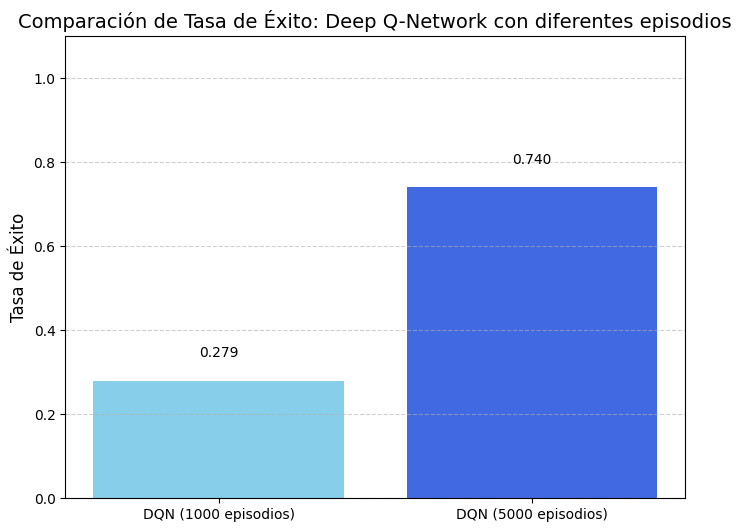

In [75]:
metricas = ['DQN (1000 episodios)', 'DQN (5000 episodios)']
tasas_exito = [tasa_exito_dqn, tasa_exito_dqn_mas_epi]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'royalblue'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito: Deep Q-Network con diferentes episodios', fontsize=14)
plt.ylim(0, 1.1)

for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


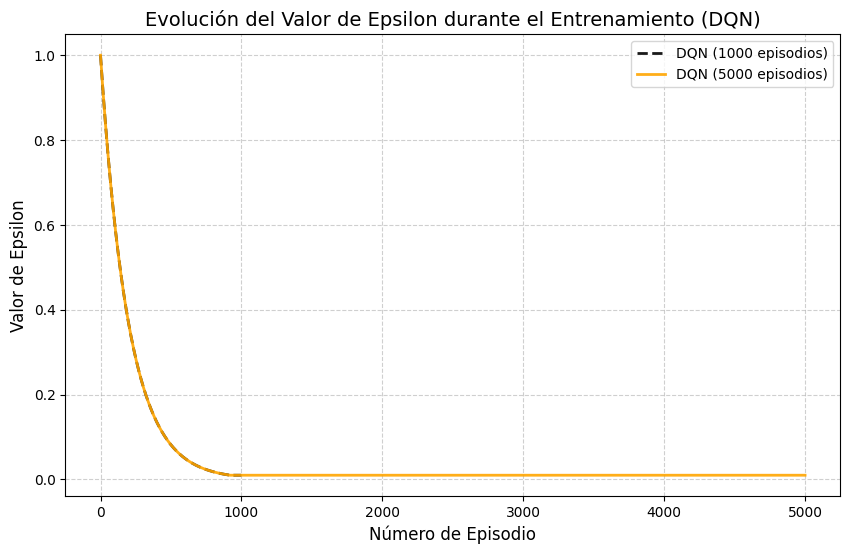

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_dqn.epsilons, label='DQN (1000 episodios)',  color='black', linestyle='--', linewidth=2, alpha=0.9)
plt.plot(agente_dqn_mas_epi.epsilons, label='DQN (5000 episodios)', color='orange',linewidth=2, alpha=0.9)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento (DQN)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### **GRAFICO TASA DE EXITO DQN**

Se nota una mejora importante en la tasa de exito en comparacion con el agente con 1000 episodios.

### **GRAFICO: Evolución del Valor de Epsilon durante el Entrenamiento DQN**
Se puede ver como epsilon al rededor de los 900-100 episodios llega a su minimo 0.01 aprox. Esto por como se contruyo su estructura en la clase del agente.

## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

##**Modificando el hiperparametro "gamma" del modelo DQN**

In [41]:
gammas = [0.3, 0.6, 0.99]
tasas_gamma = []

for g in gammas:
    print(f"\n🔧 Entrenando DQN con gamma = {g}")
    agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=g, epsilon=1.0)
    recompensas_dqn = agente_dqn.entrenar(env, episodios=5000)
    tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)
    tasas_gamma.append(tasa_exito_dqn)


🔧 Entrenando DQN con gamma = 0.3
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.050, Epsilon = 0.367, Loss = 0.0022
Episodio 400: Tasa éxito = 0.030, Epsilon = 0.135, Loss = 0.0020
Episodio 600: Tasa éxito = 0.020, Epsilon = 0.049, Loss = 0.0030
Episodio 800: Tasa éxito = 0.020, Epsilon = 0.018, Loss = 0.0017
Episodio 1000: Tasa éxito = 0.010, Epsilon = 0.010, Loss = 0.0013
Episodio 1200: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0019
Episodio 1400: Tasa éxito = 0.060, Epsilon = 0.010, Loss = 0.0025
Episodio 1600: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0024
Episodio 1800: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0026
Episodio 2000: Tasa éxito = 0.010, Epsilon = 0.010, Loss = 0.0028
Episodio 2200: Tasa éxito = 0.070, Epsilon = 0.010, Loss = 0.0024
Episodio 2400: Tasa éxito = 0.020, Epsilon = 0.010, Loss = 0.0022
Episodio 2600: Tasa éxito = 0.030, Epsilon = 0.010, Loss = 0.0019
Episodio 2800: Tasa éxito = 0.030, Epsilon = 0.0

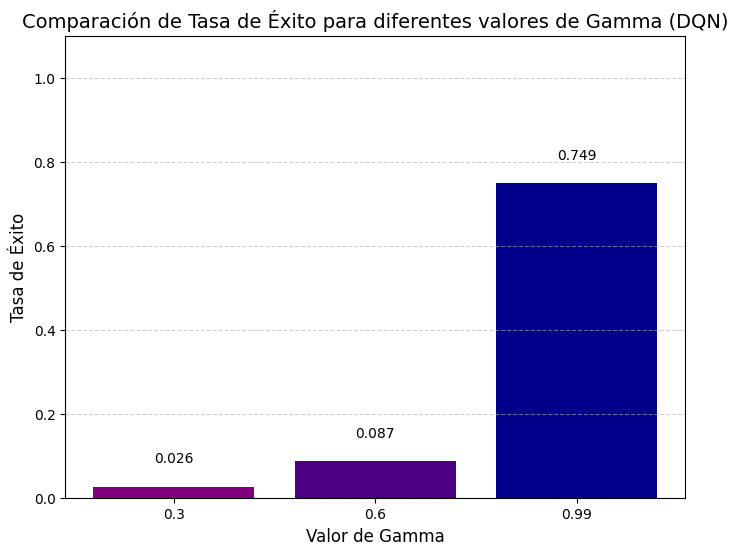

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
barras = plt.bar([str(g) for g in gammas], tasas_gamma, color=['purple', 'indigo', 'darkblue'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.xlabel('Valor de Gamma', fontsize=12)
plt.title('Comparación de Tasa de Éxito para diferentes valores de Gamma (DQN)', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Gamma controla cuánto valora el agente las recompensas futuras frente a las recompensas inmediatas.

Si gamma es alto (ej: 0.99), **el agente tiene en cuenta las recompensas futuras, o sea, piensa a largo plazo.**
Le importa no solo ganar ahora, sino obtener beneficios

**Con 0.3:** El agente solo se enfoca en recompensas inmediatas.
No valora el futuro, por eso no aprende estrategias a largo plazo.

**Con 0.6:** Empieza a valorar un poco las recompensas futuras, pero aún no lo suficiente.
Tiene un desempeño mejor, pero todavía bajo.

**Con 0.99:** El agente consigue planificar a largo plazo, considerando las consecuencias futuras de sus acciones.
Aprende políticas más estables y eficientes.

## C) Lo mismo que en B) pero para el hiperparámetro alpha.

In [43]:
lrs = [0.0001, 0.001, 0.1]
tasas_lr = []

for lr in lrs:
    print(f"\n⚙️ Entrenando DQN con lr = {lr}")
    agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n, lr=lr, gamma=0.95, epsilon=1.0)
    recompensas_dqn = agente_dqn.entrenar(env, episodios=2000)
    tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)
    tasas_lr.append(tasa_exito_dqn)


⚙️ Entrenando DQN con lr = 0.0001
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0028
Episodio 400: Tasa éxito = 0.100, Epsilon = 0.135, Loss = 0.0060
Episodio 600: Tasa éxito = 0.410, Epsilon = 0.049, Loss = 0.0081
Episodio 800: Tasa éxito = 0.650, Epsilon = 0.018, Loss = 0.0069
Episodio 1000: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0081
Episodio 1200: Tasa éxito = 0.610, Epsilon = 0.010, Loss = 0.0083
Episodio 1400: Tasa éxito = 0.550, Epsilon = 0.010, Loss = 0.0082
Episodio 1600: Tasa éxito = 0.600, Epsilon = 0.010, Loss = 0.0082
Episodio 1800: Tasa éxito = 0.540, Epsilon = 0.010, Loss = 0.0071
Episodio 2000: Tasa éxito = 0.660, Epsilon = 0.010, Loss = 0.0081

✅ Entrenamiento Deep Q-Network (DQN) completado!
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.722
Pasos promedio: 41.1

⚙️ Entrenando DQN con lr = 0.001
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa 

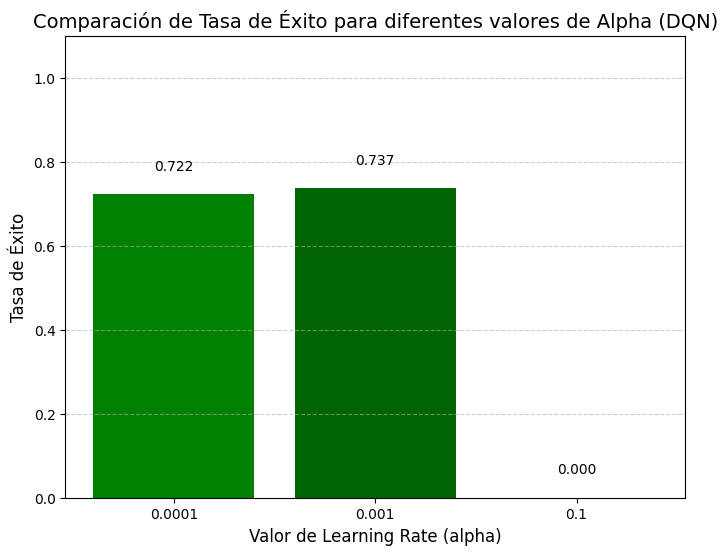

In [45]:
plt.figure(figsize=(8, 6))
barras = plt.bar([str(lr) for lr in lrs], tasas_lr, color=['green', 'darkgreen', 'red'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.xlabel('Valor de Learning Rate (alpha)', fontsize=12)
plt.title('Comparación de Tasa de Éxito para diferentes valores de Alpha (DQN)', fontsize=14)
plt.ylim(0, 1.1)

for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Cada vez que el agente actua y recibe una respuesta del entorno, ya sea recompensa o penalizacion, este **ajusta sus valores**.

Learning rate (lr) o alpha es el que le dice al agente **CÚANTO DEBE CAMBIAR ESOS VALORES** cuando aprende algo nuevo.

- Si alpha es muy alto, el agente actualiza el valor de golpe, lo que lo hace INESTABLE.
- Si es mas bajo, aprende de a poco, con paciencia. Esto lo hace mas estable.

Esto se evidencia en el grafico de los diferentes alphas, el menor, funciona muy bien y el medio un poco mejor pero el alpha alto es 0.0.
